In [9]:
import os
import pandas as pd
from blockbaxAnalyser import blockbaxAnalyser
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# --------------- SETTINGS -----------------------------------------
verbose = True # Set to True to get intermediate prints of results
sb_numbers = [148098, 148097, 148091, 148088, 148076, 148096]
temp_steps = [-20, -10, 0, 10, 20, 30, 40, 50]
temp_steps_short = [-10, 0, 10, 20]
y_steps = [-10, -5, -2, 0, 2, 5, 10]
tl_min = -2 # min x value of trendline
tl_max = 2 # max x value of trendline

plot_from_date = "2022-04-28 18:30:00"
plot_till_date = "2022-05-05 01:00:00"

In [11]:
# --------------- INITIALISATION --------------------------------------
analyser = blockbaxAnalyser(sb_numbers = sb_numbers, 
plot_from_date=plot_from_date, 
plot_till_date=plot_till_date)

analyser.dataPrep(ref_filename=os.path.join(os.path.abspath('').removesuffix('blockbaxAnalyser.py'),"Ref","jewell_ref_april.txt"), 
offset_date_start="2022-05-02 03:40:00",
offset_date_end="2022-05-02 05:35:00")

if verbose:
    i=0
    print(analyser.dfs)
    print(sb_numbers[i])
    print(analyser.dfs[i].to_string())

[                               Datetime  Temperature   Y value  Reference
Datetime                                                                 
2022-04-28 18:31:00 2022-04-28 18:31:00   -16.799999  9.713613   9.380461
2022-04-28 18:36:01 2022-04-28 18:36:01   -17.400000  9.731923   9.387061
2022-04-28 18:41:00 2022-04-28 18:41:00   -17.799999  9.719716   9.370361
2022-04-28 18:46:02 2022-04-28 18:46:02   -18.200001  9.731923   9.382961
2022-04-28 18:51:00 2022-04-28 18:51:00   -18.500000  9.725820   9.368061
...                                 ...          ...       ...        ...
2022-05-05 00:15:51 2022-05-05 00:15:51    51.099998  8.810292   9.121761
2022-05-05 00:20:51 2022-05-05 00:20:51    51.099998  8.816396   9.115361
2022-05-05 00:25:52 2022-05-05 00:25:52    51.099998  8.810292   9.096661
2022-05-05 00:30:51 2022-05-05 00:30:51    51.099998  8.804189   9.127461
2022-05-05 00:35:51 2022-05-05 00:35:51    51.099998  8.804189   9.124261

[1700 rows x 4 columns],            

In [12]:
# ------------------- GROUPING ---------------------------------------
bins_y = [-11, -7, -3.5, -1, 1, 3.5, 7, 10]
bins_temp = [-25, -15, -5, 5, 15, 25, 35, 45, 55]
for i in range(len(sb_numbers)):
    analyser.dfs[i]["Y setting"] = pd.cut(analyser.dfs[i]["Y value"], bins = bins_y, labels=y_steps)
    analyser.dfs[i]["Temp setting"] = pd.cut(analyser.dfs[i]["Temperature"], bins = bins_temp, labels=temp_steps)
    if verbose:
        print(analyser.dfs[i])
        print(analyser.dfs[0].to_string())


                               Datetime  Temperature   Y value  Reference  \
Datetime                                                                    
2022-04-28 18:31:00 2022-04-28 18:31:00   -16.799999  9.713613   9.380461   
2022-04-28 18:36:01 2022-04-28 18:36:01   -17.400000  9.731923   9.387061   
2022-04-28 18:41:00 2022-04-28 18:41:00   -17.799999  9.719716   9.370361   
2022-04-28 18:46:02 2022-04-28 18:46:02   -18.200001  9.731923   9.382961   
2022-04-28 18:51:00 2022-04-28 18:51:00   -18.500000  9.725820   9.368061   
...                                 ...          ...       ...        ...   
2022-05-05 00:15:51 2022-05-05 00:15:51    51.099998  8.810292   9.121761   
2022-05-05 00:20:51 2022-05-05 00:20:51    51.099998  8.816396   9.115361   
2022-05-05 00:25:52 2022-05-05 00:25:52    51.099998  8.810292   9.096661   
2022-05-05 00:30:51 2022-05-05 00:30:51    51.099998  8.804189   9.127461   
2022-05-05 00:35:51 2022-05-05 00:35:51    51.099998  8.804189   9.124261   

In [17]:
# ---------------- FUNCTION DEFINITIONS FOR STDTF -----------------------------
def get_corresponding_ymeans(y_setting):
    for y in range(len(y_steps)):
        if y_setting == y_steps[y]:
            return y_means[y]
def get_corresponding_ystds(y_setting):
    for y in range(len(y_steps)):
        if y_setting == y_steps[y]:
            return y_stds[y]

def get_corresponding_yrefmeans(y_setting):
    for y in range(len(y_steps)):
        if y_setting == y_steps[y]:
            return yref_means[y]
def get_corresponding_yrefstds(y_setting):
    for y in range(len(y_steps)):
        if y_setting == y_steps[y]:
            return yref_stds[y]

def get_corresponding_tempmeans(temp_setting):
    for t in range(len(temp_steps)):
        if temp_setting == temp_steps[t]:
            return temp_means[t]
def get_corresponding_tempstds(temp_setting):
    for t in range(len(temp_steps)):
        if temp_setting == temp_steps[t]:
            return temp_stds[t]
# ------------------- STANDARD TRANSFORM -------------------------------
y_lists = []
yref_lists = []
for y in y_steps:
    y_list = []
    yref_list = []
    for i in range(len(sb_numbers)):
        y_list += analyser.dfs[i].groupby("Y setting").get_group(y)["Y value"].tolist()
        yref_list += analyser.dfs[i].groupby("Y setting").get_group(y)["Reference"].tolist()
    y_lists.append(y_list)
    yref_lists.append(yref_list)
y_means = []
yref_means = []
y_stds = []
yref_stds = []
for y in y_lists:
    y_means.append(sum(y)/len(y))
    y_stds.append(np.std(y))
for yref in yref_lists:
    yref_means.append(sum(yref)/len(yref))
    yref_stds.append(np.std(yref))

temp_lists = []
for temp in temp_steps:
    temp_list = []
    for i in range(len(sb_numbers)):
            temp_list += analyser.dfs[i].groupby("Temp setting").get_group(temp)["Temperature"].tolist()
    temp_lists.append(temp_list)
temp_means = []
temp_stds = []
for temp in temp_lists:
    temp_means.append(sum(temp)/len(temp))
    temp_stds.append(np.std(temp))

for i in range(len(sb_numbers)): # Per smartbrick
    analyser.dfs[i]["Y mean"] = analyser.dfs[i].apply(lambda x: get_corresponding_ymeans(x["Y setting"]), axis=1)
    analyser.dfs[i]["Y std"] = analyser.dfs[i].apply(lambda x: get_corresponding_ystds(x["Y setting"]), axis=1)

    analyser.dfs[i]["Ref mean"] = analyser.dfs[i].apply(lambda x: get_corresponding_yrefmeans(x["Y setting"]), axis=1)
    analyser.dfs[i]["Ref std"] = analyser.dfs[i].apply(lambda x: get_corresponding_yrefstds(x["Y setting"]), axis=1)

    analyser.dfs[i]["Temp mean"] = analyser.dfs[i].apply(lambda x: get_corresponding_tempmeans(x["Temp setting"]), axis=1)
    analyser.dfs[i]["Temp std"] = analyser.dfs[i].apply(lambda x: get_corresponding_tempstds(x["Temp setting"]), axis=1)

    analyser.dfs[i]["Y stdtf"] = (analyser.dfs[i]["Y value"]-analyser.dfs[i]["Y mean"])/analyser.dfs[i]["Y std"]
    analyser.dfs[i]["Yref stdtf"] = (analyser.dfs[i]["Reference"]-analyser.dfs[i]["Ref mean"])/analyser.dfs[i]["Ref std"]
    analyser.dfs[i]["Temp stdtf"] = (analyser.dfs[i]["Temperature"]-analyser.dfs[i]["Temp mean"])/analyser.dfs[i]["Temp std"]

if verbose:
    print("Y means: ", y_means)
    print("Y standard deviations: ", y_stds)
    print("Temp means: ", temp_means)
    print("Temp standard deviations: ", temp_stds)
    print(analyser.dfs)
    print(analyser.dfs[0].to_string())

Y means:  [-10.17685972381537, -4.988873431738634, -1.921876166159272, -0.20269252587218145, 1.8942846646790423, 4.75275126491581, 9.190120490809948]
Y standard deviations:  [0.401415076122919, 0.27840066667249563, 0.216320099454811, 0.2714626221605391, 0.17965724180303677, 0.20209490764730348, 0.20370400618448262]
Temp means:  [-18.976046901134577, -9.152529206628465, 0.919629056611238, 11.537054315463518, 21.862666350719977, 31.653359244763852, 41.383880600309894, 50.8551642338808]
Temp standard deviations:  [0.3793998572645069, 0.3763683867954238, 0.30876108019740317, 0.3164346311545669, 0.2830685860437096, 0.283098710545348, 0.2967584219050258, 0.2916964165481705]
[                               Datetime  Temperature   Y value  Reference  \
Datetime                                                                    
2022-04-28 18:31:00 2022-04-28 18:31:00   -16.799999  9.713613   9.380461   
2022-04-28 18:36:01 2022-04-28 18:36:01   -17.400000  9.731923   9.387061   
2022-04-28 18:

Hieronder is de data visueel uitgezet. Elk plotje is van één specifieke smartbrick (zie legenda voor serienummer) bij één specifieke hoek. Per smartbrick zijn er dus 7 plots. Dit omdat de sterke correlatie die eerder ontdekt was ook bij een test was waarbij we één hoek aanhielden en verschillende temperaturen testten.

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148098 at angle  -10
slope: -1.052028, intercept: 0.324076
R-squared: 0.853671


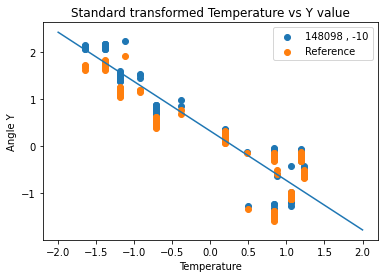

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148098 at angle  -5
slope: -1.677597, intercept: 0.321764
R-squared: 0.931424


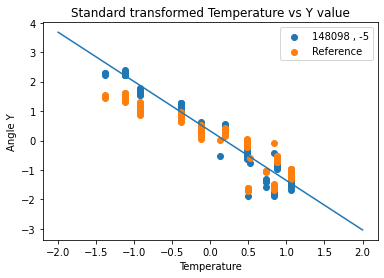

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148098 at angle  -2
slope: -1.691564, intercept: 0.240584
R-squared: 0.909746


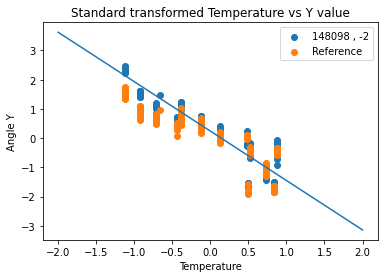

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148098 at angle  0
slope: -1.044426, intercept: 0.060450
R-squared: 0.463254


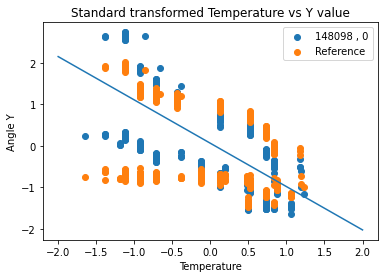

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148098 at angle  2
slope: -1.684224, intercept: -0.115474
R-squared: 0.965818


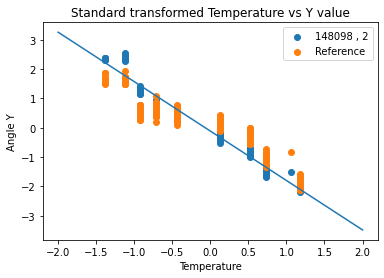

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148098 at angle  5
slope: -1.630306, intercept: -0.170801
R-squared: 0.961114


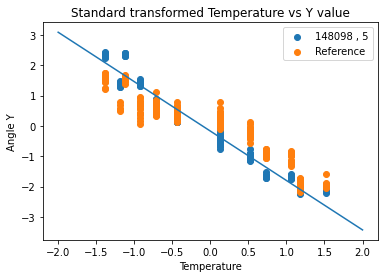

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148098 at angle  10
slope: -0.083114, intercept: -0.441799
R-squared: 0.020924


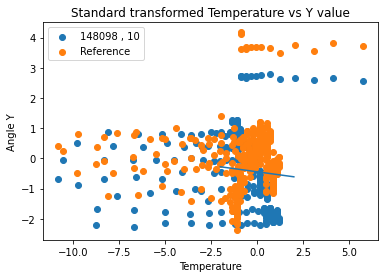

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148097 at angle  -10
slope: -1.400920, intercept: 0.258264
R-squared: 0.612681


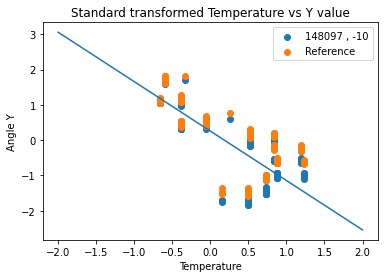

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148097 at angle  -5
slope: -2.405952, intercept: 0.478626
R-squared: 0.663734


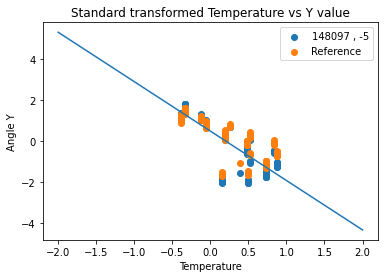

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148097 at angle  -2
slope: -3.750424, intercept: 0.507257
R-squared: 0.679800


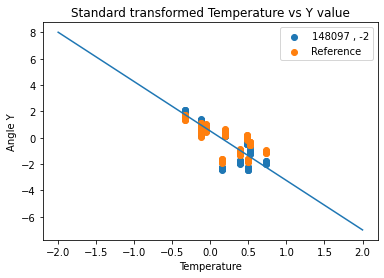

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148097 at angle  0
slope: -2.029535, intercept: 0.432261
R-squared: 0.384604


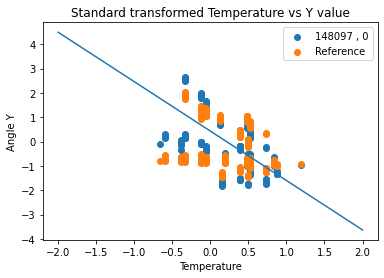

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148097 at angle  2
slope: -3.202549, intercept: 0.661637
R-squared: 0.844018


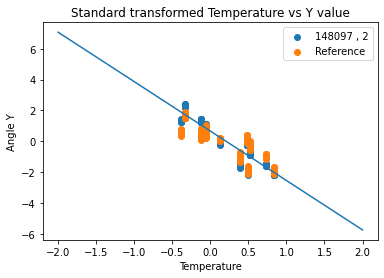

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148097 at angle  5
slope: -2.611297, intercept: 0.388461
R-squared: 0.907087


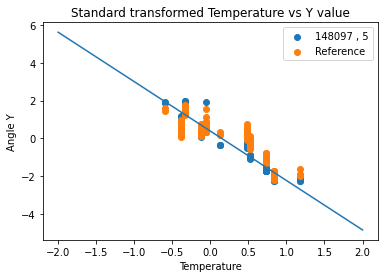

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148097 at angle  10
slope: 0.003022, intercept: -0.248022
R-squared: 0.000028


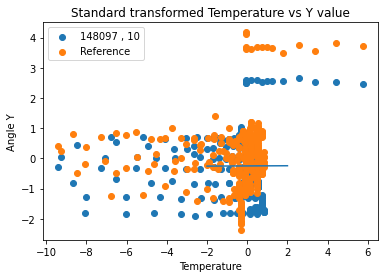

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148091 at angle  -10
slope: -0.850187, intercept: 0.145017
R-squared: 0.605154


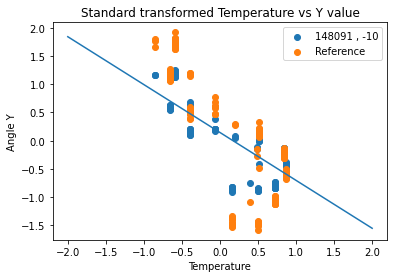

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148091 at angle  -5
slope: -1.202277, intercept: 0.103976
R-squared: 0.589404


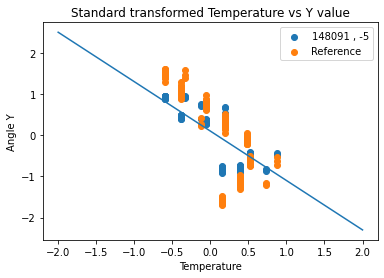

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148091 at angle  -2
slope: -1.218539, intercept: -0.044745
R-squared: 0.564812


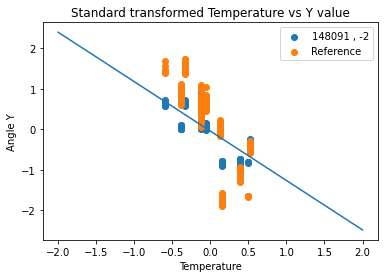

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148091 at angle  0
slope: -0.347097, intercept: -0.143233
R-squared: 0.022182


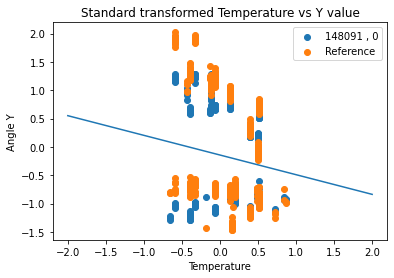

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148091 at angle  2
slope: -0.599530, intercept: -0.292120
R-squared: 0.416102


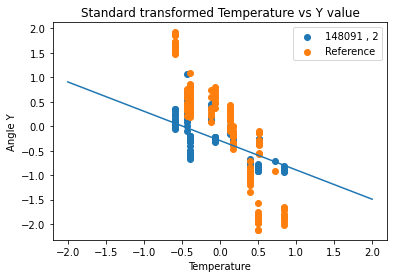

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148091 at angle  5
slope: -0.537000, intercept: -0.361197
R-squared: 0.548523


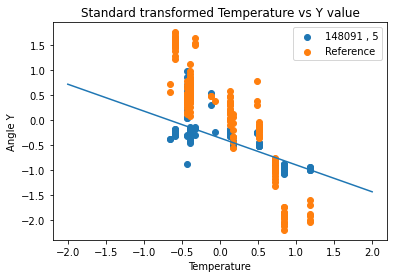

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148091 at angle  10
slope: -0.000576, intercept: -0.171117
R-squared: 0.000004


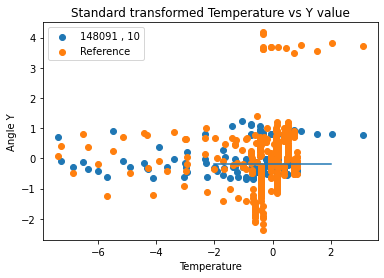

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148088 at angle  -10
slope: 1.042269, intercept: 0.185028
R-squared: 0.664109


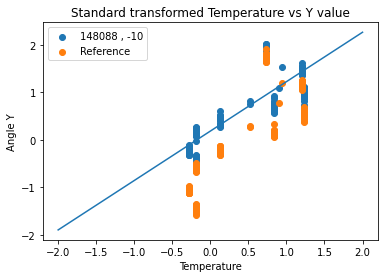

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148088 at angle  -5
slope: 1.232652, intercept: -0.009834
R-squared: 0.816036


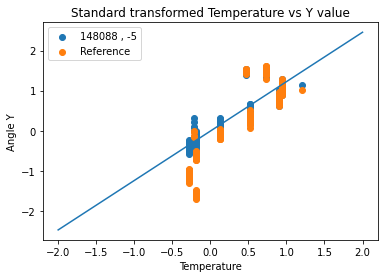

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148088 at angle  -2
slope: 1.092028, intercept: -0.010266
R-squared: 0.632251


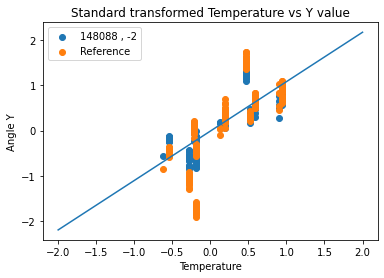

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148088 at angle  0
slope: 0.449647, intercept: -0.062826
R-squared: 0.065826


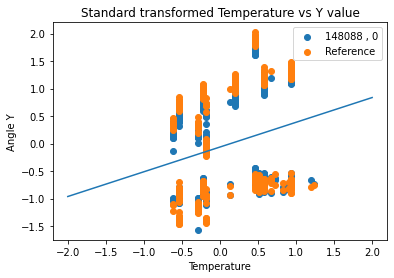

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148088 at angle  2
slope: 1.230263, intercept: -0.373315
R-squared: 0.451206


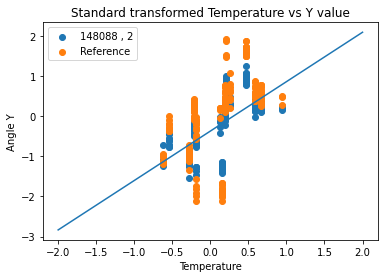

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148088 at angle  5
slope: 1.128393, intercept: -0.456371
R-squared: 0.347524


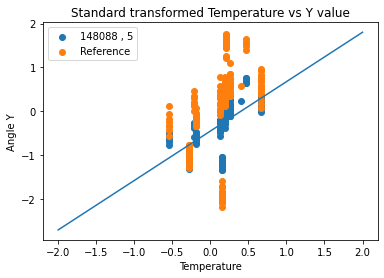

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148088 at angle  10
slope: 0.105181, intercept: -0.851005
R-squared: 0.191438


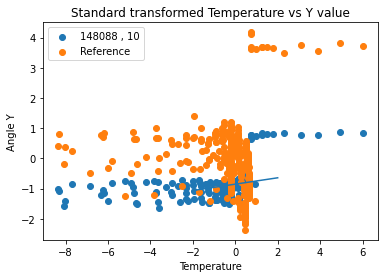

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148076 at angle  -10
slope: 0.711870, intercept: -0.010220
R-squared: 0.818319


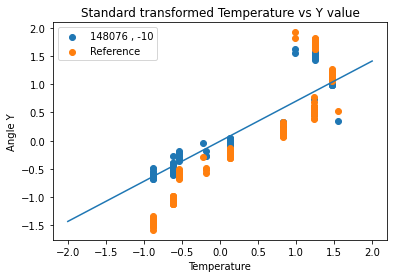

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148076 at angle  -5
slope: 0.871448, intercept: -0.212983
R-squared: 0.861603


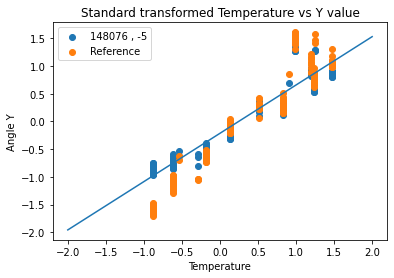

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148076 at angle  -2
slope: 1.122966, intercept: -0.270433
R-squared: 0.849266


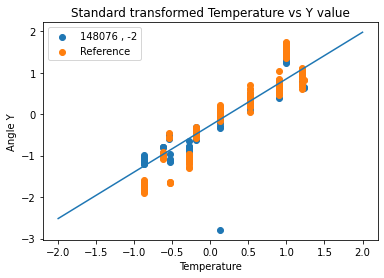

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148076 at angle  0
slope: 0.396744, intercept: -0.064775
R-squared: 0.100479


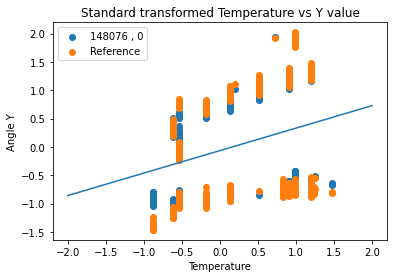

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148076 at angle  2
slope: 0.802041, intercept: 0.127387
R-squared: 0.649659


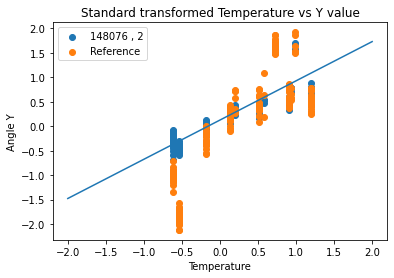

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148076 at angle  5
slope: 0.929159, intercept: 0.038536
R-squared: 0.832058


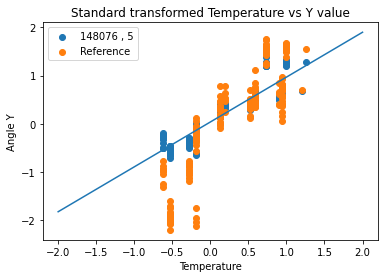

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148076 at angle  10
slope: 0.100000, intercept: 0.563293
R-squared: 0.242823


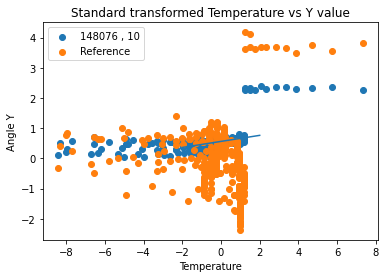

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148096 at angle  -10
slope: 1.401099, intercept: -1.034092
R-squared: 0.707783


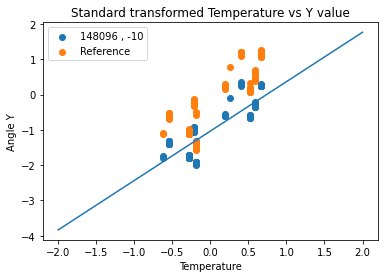

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148096 at angle  -5
slope: 2.336165, intercept: -0.572644
R-squared: 0.754806


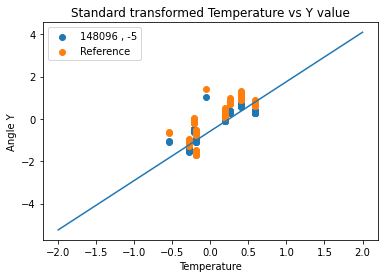

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148096 at angle  -2
slope: 2.643714, intercept: -0.296751
R-squared: 0.747868


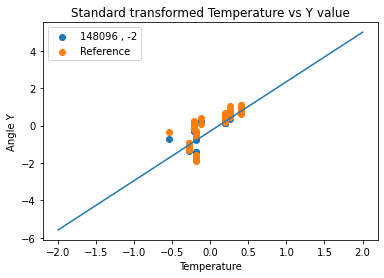

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148096 at angle  0
slope: 1.081547, intercept: -0.104457
R-squared: 0.097547


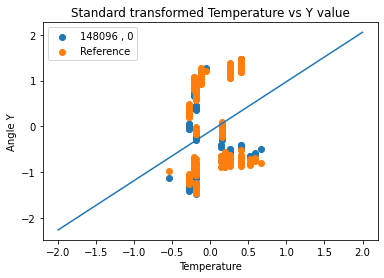

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148096 at angle  2
slope: 1.193838, intercept: 0.175935
R-squared: 0.078527


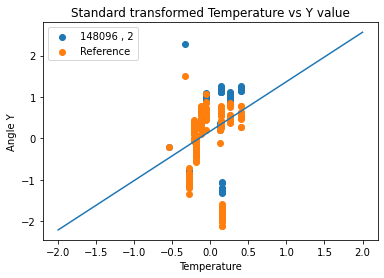

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148096 at angle  5
slope: 0.585267, intercept: 0.771171
R-squared: 0.017722


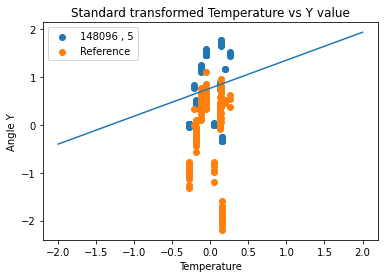

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148096 at angle  10
slope: 0.034468, intercept: 1.263823
R-squared: 0.013741


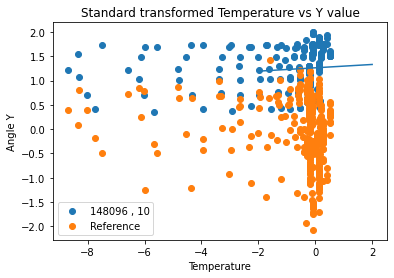

In [18]:
# -------------------- PLOT STANDARD TRANSFORMED DATA (T, Y) ------------------------------
for i in range(len(sb_numbers)):
    for y in range(len(y_steps)):
        analyser.trendlineStdTF_per_y(i,y_value=y_steps[y], y_index=y)
        plt.scatter(analyser.dfs[i].groupby("Y setting").get_group(y_steps[y])['Temp stdtf'], analyser.dfs[i].groupby("Y setting").get_group(y_steps[y])['Y stdtf'], label=str(sb_numbers[i])+ ' , '+str(y_steps[y]))
        plt.scatter(analyser.dfs[i].groupby("Y setting").get_group(y_steps[y])['Temp stdtf'], analyser.dfs[i].groupby("Y setting").get_group(y_steps[y])['Yref stdtf'], label="Reference")
        if analyser.slope != None:
            x = np.linspace(-2,2,1000)
            y = analyser.slope[y] * x + analyser.intercept[y]
            plt.plot(x,y)

        plt.legend()
        plt.title("Standard transformed Temperature vs Y value")
        plt.xlabel('Temperature')
        plt.ylabel('Angle Y')
        plt.show() 
    analyser.slope = None
    analyser.intercept = None   

Op het oog vallen er een paar dingen op:
1. Geen erg sterke correlatie tussen temperatuur en Y
2. Bij de ingesteld hoek van 10 graden loopt de genormaliseerde temperatuur sterk uiteen.

Opmerking: Een verschil met de vorige analyse is dat in de vorige analyse met genormaliseerde data alléén de Y genormaliseerd was, niet de temperatuur. (dit is hieronder geprobeerd)

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148098 at angle  -10
slope: -0.048555, intercept: 0.980123
R-squared: 0.984474


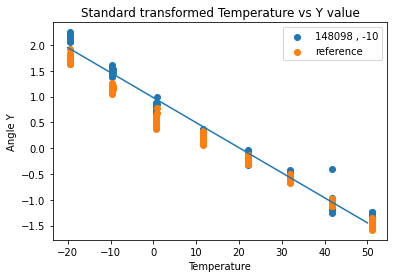

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148098 at angle  -5
slope: -0.058664, intercept: 1.125438
R-squared: 0.991064


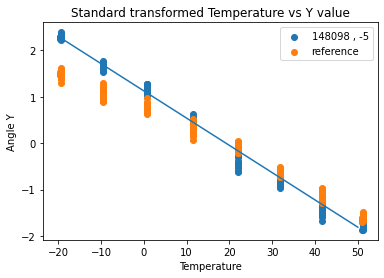

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148098 at angle  -2
slope: -0.054655, intercept: 1.190514
R-squared: 0.984499


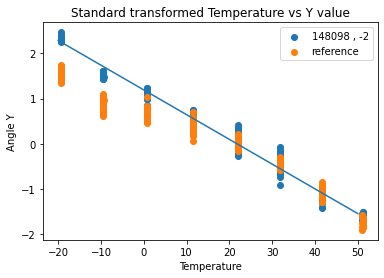

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148098 at angle  0
slope: -0.033154, intercept: 0.683424
R-squared: 0.455353


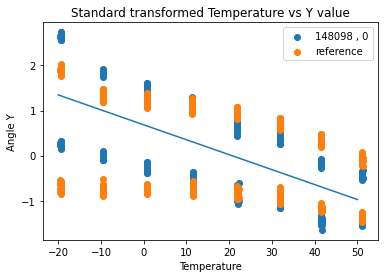

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148098 at angle  2
slope: -0.059095, intercept: 0.993696
R-squared: 0.985377


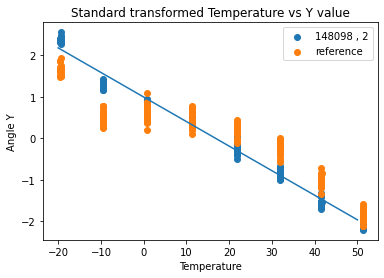

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148098 at angle  5
slope: -0.061379, intercept: 0.942731
R-squared: 0.990494


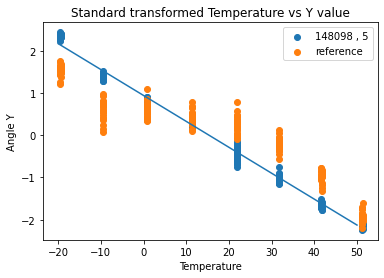

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148098 at angle  10
slope: -0.051637, intercept: 0.493227
R-squared: 0.942459


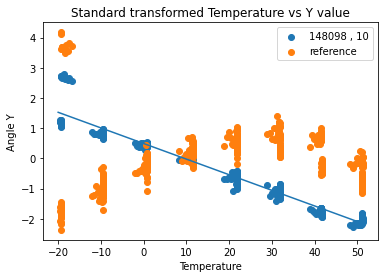

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148097 at angle  -10
slope: -0.048696, intercept: 0.579863
R-squared: 0.990261


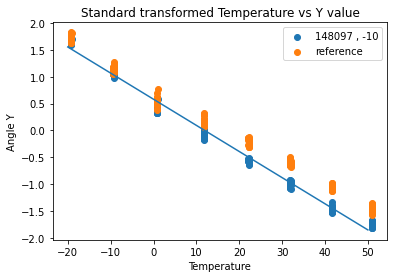

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148097 at angle  -5
slope: -0.054638, intercept: 0.719046
R-squared: 0.994146


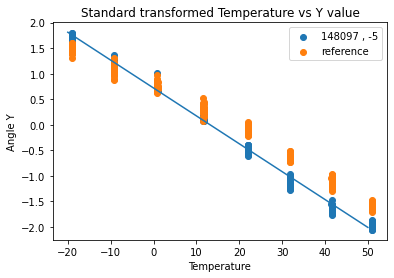

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148097 at angle  -2
slope: -0.062009, intercept: 0.851695
R-squared: 0.991209


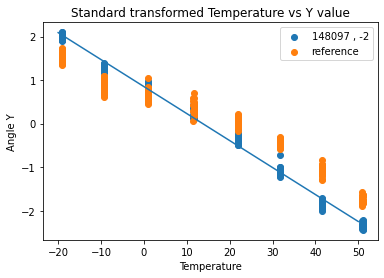

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148097 at angle  0
slope: -0.035896, intercept: 0.663748
R-squared: 0.475320


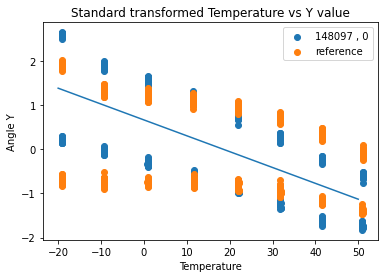

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148097 at angle  2
slope: -0.060136, intercept: 1.029860
R-squared: 0.989775


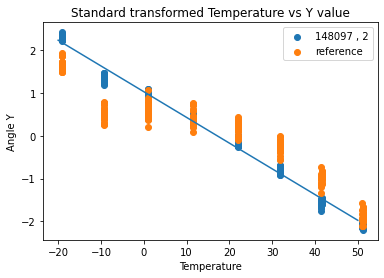

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148097 at angle  5
slope: -0.055987, intercept: 0.753564
R-squared: 0.992893


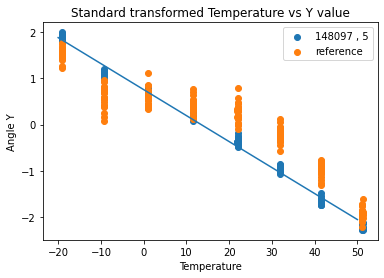

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148097 at angle  10
slope: -0.044229, intercept: 0.499754
R-squared: 0.926242


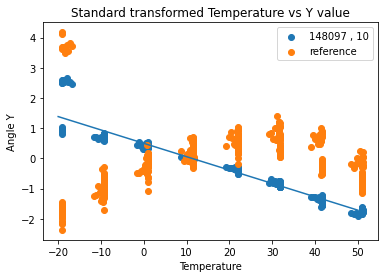

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148091 at angle  -10
slope: -0.027489, intercept: 0.416557
R-squared: 0.958009


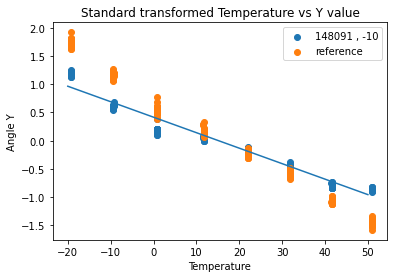

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148091 at angle  -5
slope: -0.025565, intercept: 0.401605
R-squared: 0.937082


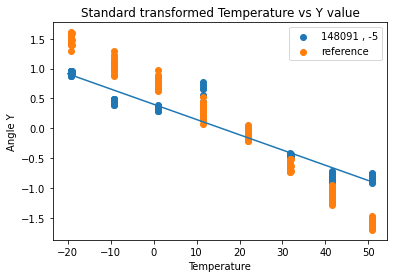

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148091 at angle  -2
slope: -0.019166, intercept: 0.211157
R-squared: 0.768839


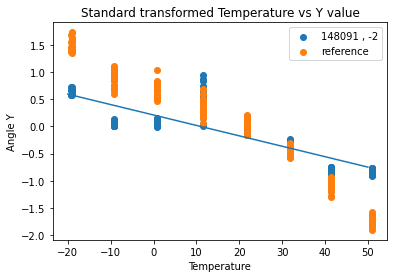

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148091 at angle  0
slope: -0.004489, intercept: -0.095896
R-squared: 0.014745


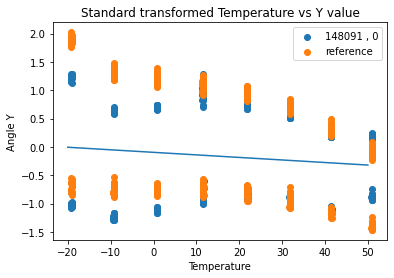

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148091 at angle  2
slope: -0.009544, intercept: -0.133623
R-squared: 0.298081


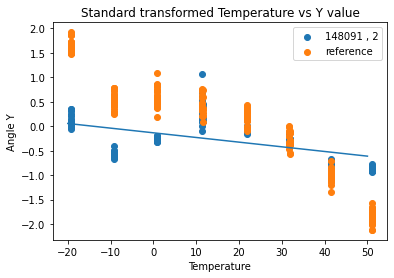

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148091 at angle  5
slope: -0.010097, intercept: -0.227577
R-squared: 0.346744


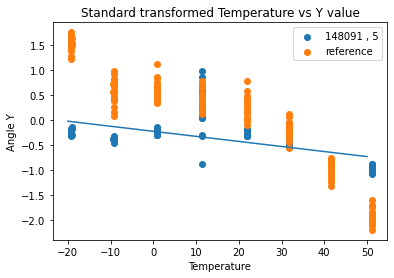

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148091 at angle  10
slope: -0.000688, intercept: -0.159205
R-squared: 0.001781


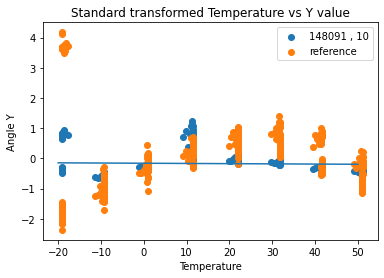

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148088 at angle  -10
slope: -0.032810, intercept: 1.166446
R-squared: 0.978810


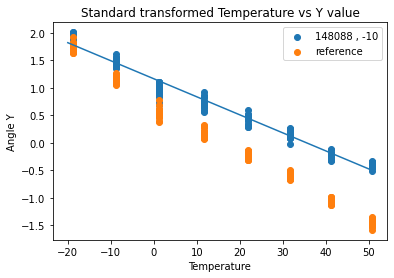

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148088 at angle  -5
slope: -0.028511, intercept: 0.831081
R-squared: 0.966067


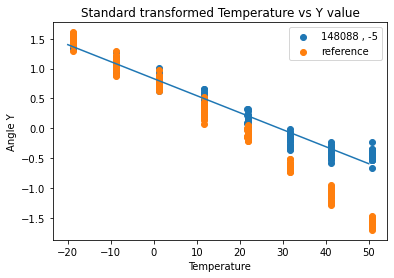

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148088 at angle  -2
slope: -0.027342, intercept: 0.626552
R-squared: 0.962553


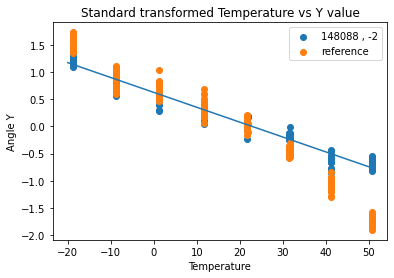

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148088 at angle  0
slope: -0.014379, intercept: 0.230624
R-squared: 0.136553


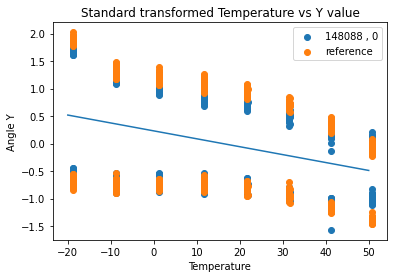

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148088 at angle  2
slope: -0.030246, intercept: 0.279830
R-squared: 0.933363


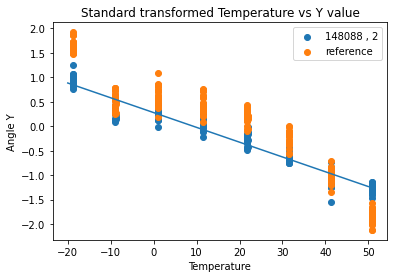

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148088 at angle  5
slope: -0.025508, intercept: 0.099088
R-squared: 0.955966


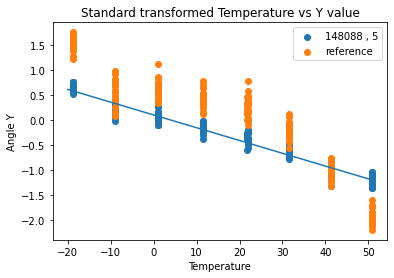

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148088 at angle  10
slope: -0.012894, intercept: -0.672877
R-squared: 0.520034


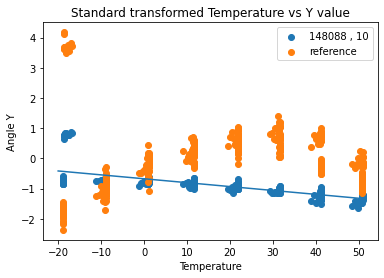

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148076 at angle  -10
slope: -0.030091, intercept: 0.740579
R-squared: 0.959728


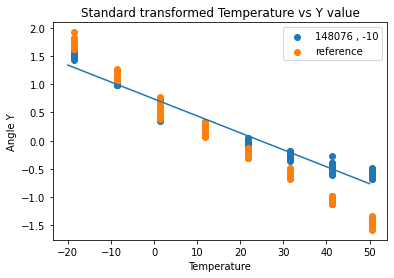

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148076 at angle  -5
slope: -0.032566, intercept: 0.619430
R-squared: 0.979952


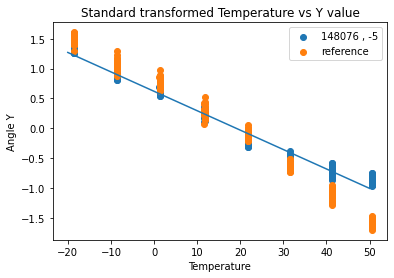

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148076 at angle  -2
slope: -0.035459, intercept: 0.643173
R-squared: 0.930275


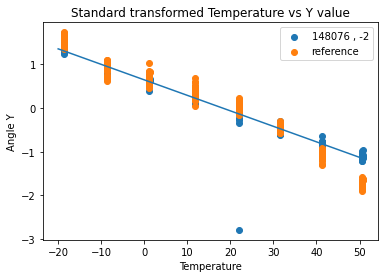

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148076 at angle  0
slope: -0.014428, intercept: 0.284227
R-squared: 0.130456


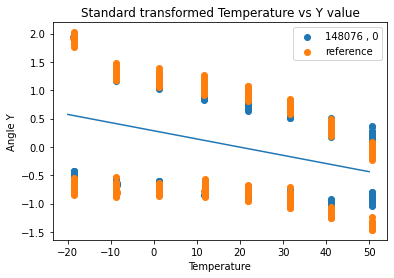

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148076 at angle  2
slope: -0.025708, intercept: 0.750773
R-squared: 0.888859


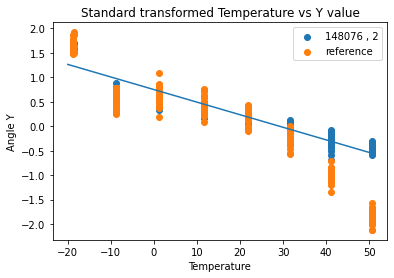

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148076 at angle  5
slope: -0.023682, intercept: 0.646658
R-squared: 0.956682


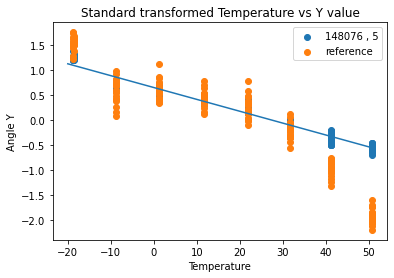

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148076 at angle  10
slope: -0.010362, intercept: 0.711963
R-squared: 0.381603


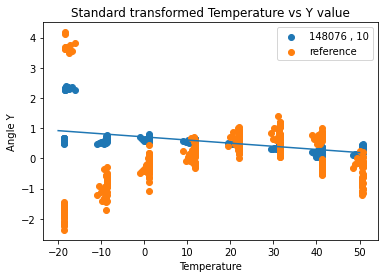

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148096 at angle  -10
slope: -0.037182, intercept: -0.163098
R-squared: 0.989940


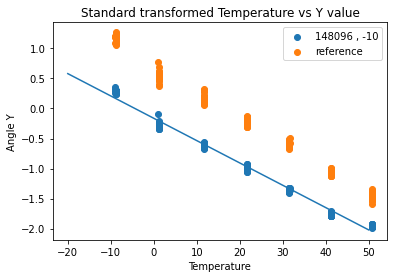

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148096 at angle  -5
slope: -0.040795, intercept: 0.338288
R-squared: 0.988419


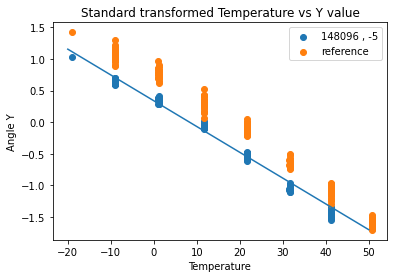

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148096 at angle  -2
slope: -0.039557, intercept: 0.527069
R-squared: 0.983133


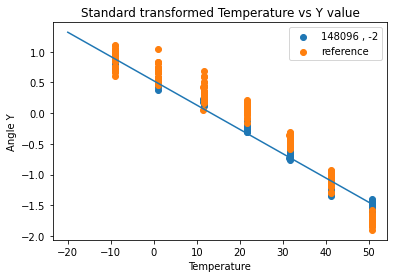

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148096 at angle  0
slope: -0.022379, intercept: 0.361001
R-squared: 0.243489


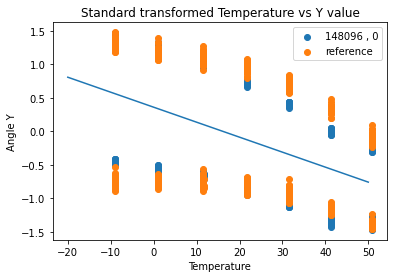

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148096 at angle  2
slope: -0.043060, intercept: 1.026117
R-squared: 0.968657


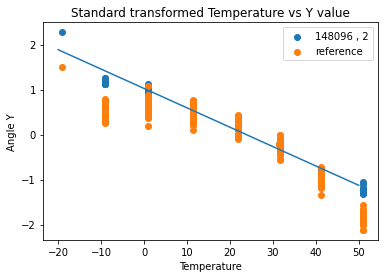

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148096 at angle  5
slope: -0.034682, intercept: 1.504824
R-squared: 0.989025


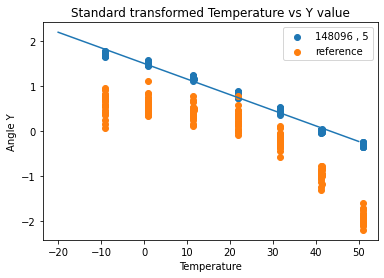

----------------------------------------------------------------------------------------------------
Trendline on standard transformed data of SmartBrick  148096 at angle  10
slope: -0.021270, intercept: 1.664301
R-squared: 0.943796


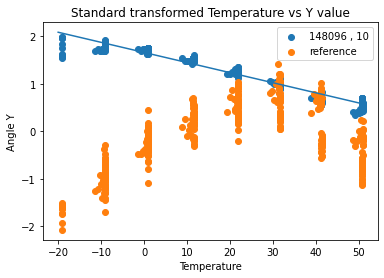

In [19]:
# ------------------------- NON-STDTF TEMPERATURE -------------------------------
for i in range(len(sb_numbers)):
    for y in range(len(y_steps)):
        analyser.trendlineStdTF_per_y_notf_temp(i,y_value=y_steps[y], y_index=y)
        plt.scatter(analyser.dfs[i].groupby("Y setting").get_group(y_steps[y])['Temperature'], analyser.dfs[i].groupby("Y setting").get_group(y_steps[y])['Y stdtf'], label=str(sb_numbers[i])+ ' , '+str(y_steps[y]))
        plt.scatter(analyser.dfs[i].groupby("Y setting").get_group(y_steps[y])['Temperature'], analyser.dfs[i].groupby("Y setting").get_group(y_steps[y])['Yref stdtf'], label='reference')

        if analyser.slope != None:
            x = np.linspace(-20,50,1000)
            y = analyser.slope[y] * x + analyser.intercept[y]
            plt.plot(x,y)

        plt.legend()
        plt.title("Standard transformed Temperature vs Y value")
        plt.xlabel('Temperature')
        plt.ylabel('Angle Y')
        plt.show() 
    analyser.slope = None
    analyser.intercept = None   

Uit deze plots zien we een redelijk sterke correlatie tussen de temperatuur en standaard getransformeerde Y. 
Hieruit wordt ook duidelijk dat de grote spreiding die waargenomen was in het vorige block volledig attribueerbaar is aan de hysterese die plaatsvindt omdat de y stappen [10, 5, 2, 0, 2, -2, -5, -10, 0, 10] zijn, en dus dat de hoek 10 2x voorkomt. Wat opmerkelijk is is dat de hysterese bij de 0 hoek wel over de hele temperatuursrange aanwezig is, maar bij de 10 hoek alleen bij de temperatuur -20.


To do list
[x] Group data based on y setting and temp setting
[x] Normalise data based on stdtransform
[x] Plot normalised data and determine R2 and trendline
[ ] Analyse and evaluate
[ ] Group smartbricks based on R2 and trendline slope/intersect
[ ] Create model for well-correlated smartbricks